In [1]:
# Author: Yichun Zhao

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt


-----------------------DATA PROCESSING-----------------------

Samples of input images:


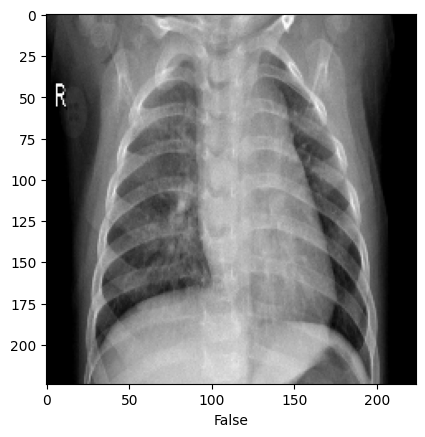

[[32 34 45 ...  0  0  0]
 [30 44 38 ...  0  0  0]
 [33 45 38 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


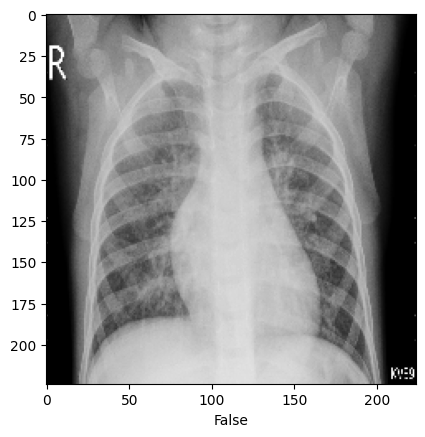

[[45 51 62 ...  0  0  0]
 [45 54 60 ...  0  0  0]
 [47 51 55 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  9  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


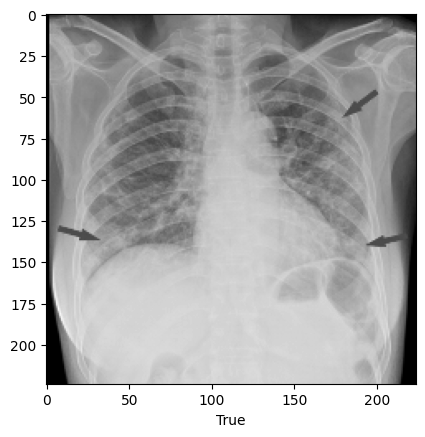

[[ 0  0 49 ...  0  0  0]
 [ 0  0 59 ...  0  0  0]
 [ 0  0 86 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]]


In [2]:
# importing data
print("\n-----------------------DATA PROCESSING-----------------------\n")
import os
import imutils
import cv2

#These lines create empty lists to store the processed images and their corresponding labels
images = []
labels = []


#This line sets the path to the directory containing the images labeled as "yes"
yes_path = os.path.abspath('')+"/dataset/train_test/yes/"
for file in os.listdir(yes_path):#This line starts a loop that iterates over the files in the "yes" directory.
    # This line reads the image file
    #converts it to grayscale using the cv2.IMREAD_GRAYSCALE flag
    image = cv2.imread(yes_path+file, cv2.IMREAD_GRAYSCALE) 
    # resize images to same size
    image = cv2.resize(image, (224, 224)) #This line resizes the image to a specific width and height 
    images.append(image) #line adds the processed image to the images list
    labels.append(True) #append the label (True) to the labels list
    
    
#This line sets the path to the directory containing the images labeled as "no"  
no_path = os.path.abspath('')+"/dataset/train_test/no/"
for file in os.listdir(no_path):#This line starts a loop that iterates over the files in the "no" directory
    # This line reads the image file
    #converts it to grayscale using the cv2.IMREAD_GRAYSCALE flag
    image = cv2.imread(no_path+file, cv2.IMREAD_GRAYSCALE)
    # resize images to same size
    image = cv2.resize(image, (224, 224)) #This line resizes the image to a specific width and height
    images.append(image) #line adds the processed image to the images list
    labels.append(False) #append the label (False) to the labels list

# visualize input images
print("Samples of input images:")

#These lines import the random module and select three random indices from the range 0 to 49 
  #(inclusive) to show a subset of images.
import random
for i in random.sample(range(0, 50), 3):
    plt.imshow(images[i], cmap='gray') #This line displays the selected image
    plt.xlabel(labels[i]) #This line adds a label to the x-axis of the image plot
    plt.show()   #This line displays the image plot 
    print(images[i])

# normalize and reshape into appropriate dimensions
#This line converts the images list to a NumPy array and normalizes the pixel values by dividing them by 255
images = np.array(images)/255 
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) #TF needs 4D shaped data
labels = np.array(labels) * 1
labels = labels.reshape(labels.shape[0], -1) #2D output data

In [3]:
# k fold cross validation
from sklearn.model_selection import KFold

#These lines define the number of folds 
#Creates a KFold object: kf, with the specified number of splits and the option to shuffle the data
k = 10
kf = KFold(n_splits=k, shuffle=True)

# Model building: 
#     The code defines a neural network model using Keras, following the architecture of AlexNet. 
#     The model includes convolutional layers, batch normalization, max pooling, flatten, hidden layers, and an output layer. 
#     The model is compiled with the binary cross-entropy loss function, Adam optimizer, and additional metrics to evaluate accuracy, precision, and recall.

# build neural net
print("\n-----------------------BUILDING NEURAL NET-----------------------\n")

# build CNN with reference to the AlexNet architecture
# refer to https://www.nature.com/articles/s41598-019-42557-4
model = keras.models.Sequential()
# conv layer 1 with 16 3x3 filters with padding
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# normalize batch after activation to improve computing time
model.add(BatchNormalization())
# max pool 1
model.add(MaxPooling2D((2, 2),strides=2))
# conv layer 2 with 32 3x3 filters
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# normalize batch
model.add(BatchNormalization())
# max pool 2
model.add(MaxPooling2D((2, 2),strides=2))
model.add(Flatten())
# hidden layer
model.add(Dense(128, activation='relu'))
# normalize batch
model.add(BatchNormalization())
# output layer for binary output
model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("\n-----------------------TRAINING MODEL-----------------------\n")

fold_num = 1
for train, test in kf.split(images, labels): #Within each fold, the model is trained on the training data and then evaluated on the testing data
    print("Training for fold ", fold_num, "...\n")
    # within each fold, we train and test our network
    
    #This line trains the model using the training data for a specified number of epochs (5) and with a batch size of 9
    model.fit(images[train], labels[train], epochs=5, batch_size=9)
    
    #This line evaluates the model's performance on the testing data 
       #and stores the loss, accuracy, precision, and recall values in the respective variables
    test_loss, test_acc, test_prec, test_rec = model.evaluate(images[test], labels[test])
    print("\nLoss from testing: ", test_loss, "")
    print("Accuracy from testing: ", test_acc, "")
    print("Precision from testing: ", test_prec, "")
    print("Recall from testing: ", test_rec, "\n")
    
    fold_num = fold_num+1 # The loop continues for the remaining folds until all folds have been processed



-----------------------BUILDING NEURAL NET-----------------------


-----------------------TRAINING MODEL-----------------------

Training for fold  1 ...

Epoch 1/5
5/5 [==============================] - 4s 373ms/step - loss: 0.4609 - accuracy: 0.7778 - precision: 0.7727 - recall: 0.7727
Epoch 2/5
5/5 [==============================] - 2s 427ms/step - loss: 0.2085 - accuracy: 0.9111 - precision: 0.8750 - recall: 0.9545
Epoch 3/5
5/5 [==============================] - 2s 398ms/step - loss: 0.0579 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/5
5/5 [==============================] - 2s 371ms/step - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 502ms/step - loss: 0.7131 - accuracy: 0.4000 - precision: 0.0000e+00 - recall: 0.0000e+00

Loss from testing:  0.7131369113922119 
Accuracy from testing:  0.4000000059604645 
Precision from testing:  0.0 
Recall from testing:  0.0 

Training for fold  2 .

5/5 [==============================] - 2s 374ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/5
5/5 [==============================] - 2s 368ms/step - loss: 5.8677e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 75ms/step - loss: 0.0822 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

Loss from testing:  0.08220978081226349 
Accuracy from testing:  1.0 
Precision from testing:  1.0 
Recall from testing:  1.0 

Training for fold  10 ...

Epoch 1/5
5/5 [==============================] - 2s 356ms/step - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2/5
5/5 [==============================] - 2s 356ms/step - loss: 6.7530e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/5
5/5 [==============================] - 2s 378ms/step - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/5
5/5 [============================

In [4]:
print("\n-----------------------SUMMARY-----------------------\n")
model.summary()

# model visualization
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')


-----------------------SUMMARY-----------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                


In [5]:
# The provided code displays the summary of the neural network model 
   # and also provides an option for visualizing the model's architecture

# save keras model
model.save(os.path.abspath('')+"/model")

# save to tfjs model for web app
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, os.path.abspath('')+"/webapp/tfjs_model")

INFO:tensorflow:Assets written to: C:\Users\17789\anaconda3\envs\covid19-cnn-part-1\covid19-ai-cnn-classifier-master/model\assets


INFO:tensorflow:Assets written to: C:\Users\17789\anaconda3\envs\covid19-cnn-part-1\covid19-ai-cnn-classifier-master/model\assets
